In [150]:
import requests
import pandas as pd
import geopandas as gpd

%matplotlib inline

In [56]:
#Build the request and parameters to fetch county features
#  from the NOAA ArcGIS map server end point
stateFIPS = 37 #This is NC

url = 'https://nowcoast.noaa.gov/arcgis/rest/services/nowcoast/mapoverlays_political/MapServer/find'
params = {'searchText':stateFIPS,
          'contains':'true',
          'searchFields':'STATEFP',
          'sr':'',
          'layers':'2',
          'layerDefs':'',
          'returnGeometry':'true',
          'maxAllowableOffset':'',
          'geometryPrecision':'',
          'dynamicLayers':'',
          'returnZ':'false',
          'returnM':'false',
          'gdbVersion':'',
          'returnUnformattedValues':'false',
          'returnFieldName':'false',
          'datumTransformations':'',
          'layerParameterValues':'',
          'mapRangeValues':'',
          'layerRangeValues':'',
          'f':'json'}

In [6]:
#Fetch the data
response = requests.get(url,params)

In [19]:
#Convert to a JSON object (i.e. a dictionary)
respons_js = response.json()

In [24]:
#The 'results' object contains a record for each county returned
results = respons_js['results']
len(results)

100

In [30]:
#Within each item in the results object are the following items
results[0].keys()

attributes          object
displayFieldName    object
foundFieldName      object
geometry            object
geometryType        object
layerId              int64
layerName           object
value               object
dtype: object

In [59]:
#The 'attributes' item contains the feature attributes
results[0]['attributes']

{u'AFFGEOID': u'0500000US37015',
 u'ALAND': u'1811097673',
 u'AWATER': u'108727758',
 u'COUNTYFP': u'015',
 u'COUNTYNS': u'01026334',
 u'FID': u'159',
 u'GEOID': u'37015',
 u'LSAD': u'06',
 u'NAME': u'Bertie',
 u'STATEFP': u'37',
 u'Shape': u'Polygon'}

In [61]:
#And the geometry object contains the shape
results[0]['geometry']

{u'rings': [[[-8608078.87744889, 4310879.947869732],
   [-8607855.681813259, 4311157.199401064],
   [-8607283.054183457, 4311298.513661726],
   [-8607034.255056638, 4311564.619169095],
   [-8606785.344632704, 4312363.801388674],
   [-8606679.591093063, 4312576.761309607],
   [-8606465.968933858, 4312789.725423373],
   [-8604441.846024798, 4313053.388036737],
   [-8604014.71301244, 4313159.460997633],
   [-8603356.146725837, 4313691.63226638],
   [-8603036.771017909, 4313902.138504786],
   [-8602309.965851361, 4314167.756942879],
   [-8601812.256260224, 4314273.703053501],
   [-8601279.258377463, 4314326.194305609],
   [-8599856.483525068, 4314199.857638092],
   [-8599358.662606183, 4314110.444661026],
   [-8599111.978533875, 4313985.6259121755],
   [-8598792.602814078, 4313914.124437068],
   [-8598526.103873806, 4313967.027238429],
   [-8598242.016453078, 4314126.563792094],
   [-8597955.70264633, 4314392.738811895],
   [-8597228.897491638, 4314942.60659493],
   [-8597173.905659784, 43

In [72]:
#Create a dataFrame from the results, 
#  keeping just the attributes and geometry objects
df = pd.DataFrame(results,columns=('attributes','geometry'))
df.head()

,attributes,geometry
0,"{u'AFFGEOID': u'0500000US37015', u'NAME': u'Be...","{u'rings': [[[-8608078.87744889, 4310879.94786..."
1,"{u'AFFGEOID': u'0500000US37055', u'NAME': u'Da...","{u'rings': [[[-8429869.786865463, 4291798.1838..."
2,"{u'AFFGEOID': u'0500000US37101', u'NAME': u'Jo...","{u'rings': [[[-8761804.792557526, 4234648.8060..."
3,"{u'AFFGEOID': u'0500000US37111', u'NAME': u'Mc...","{u'rings': [[[-9160749.25508372, 4257980.58478..."
4,"{u'AFFGEOID': u'0500000US37117', u'NAME': u'Ma...","{u'rings': [[[-8616429.51120074, 4301301.15310..."


In [90]:
#Explode the dictionary values into fields
dfCounties = df['attributes'].apply(pd.Series)
dfGeom = df['geometry'].apply(pd.Series)

In [100]:
#Combine the two
dfAll = pd.concat((dfCounties,dfGeom),axis='rows')
dfAll.columns

Index([u'AFFGEOID', u'ALAND', u'AWATER', u'COUNTYFP', u'COUNTYNS', u'FID',
       u'GEOID', u'LSAD', u'NAME', u'STATEFP', u'Shape', u'rings',
       u'spatialReference'],
      dtype='object')

In [118]:
#Demo creating a shapely polygnon from the JSON ring
rings = dfAll['rings'][0]
print "There is/are {} ring(s)".format(len(rings))
print "There are {} vertices in the first ring".format(len(rings[0]))
print "The first vertex is at {}".format(rings[0][0])

There is/are 1 ring(s)
There are 524 vertices in the first ring
The first vertex is at [-8608078.87744889, 4310879.947869732]


In [124]:
from shapely.geometry import LinearRing
ring = rings[0]
r = LinearRing(ring)
s = Polygon(r)

In [144]:
#https://shapely.readthedocs.io/en/latest/manual.html#polygons
from shapely.geometry import Polygon
from shapely.geometry import LinearRing
def polyFromRing(ring):
    r = LinearRing(ring)
    s = Polygon(r)
    return r
dfAll['geometry']=dfAll.apply(lambda x: Polygon(x.rings[0]),axis=1)

In [147]:
gdf=gpd.GeoDataFrame(dfAll)

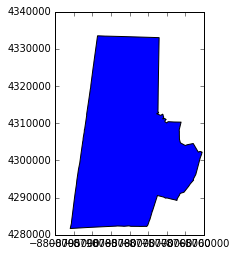

In [153]:
gdf[gdf['NAME'] == 'Durham'].plot();